DQN中有两个关键技术，一个是经验回放，一个是双网络结构（策略网络和目标网络）。DQN算法通过贪婪法直接获得目标Q值，贪婪法通过最大化的方式使Q值快速向可能的优化目标收敛，但是这容易导致过估计Q值的问题，使得模型具有较大的偏差。因此为了避免这种情况的出现，提出了Double DQN算法，采用Double DQN算法解耦动作的选择和目标Q值的计算，以解决过估计Q值的问题。

### 定义网络模型

Double DQN除了在更新时对期望Q值的近似方式与DQN不同之外，其他都是相同的

In [1]:
import torch.nn as nn
import torch.nn.functional as F
class Model(nn.Module):
    def __init__(self, n_states,n_actions,hidden_dim=256):
        """ 初始化q网络，为全连接网络
        """
        super(Model, self).__init__()
        self.fc1 = nn.Linear(n_states, hidden_dim) # 输入层
        self.fc2 = nn.Linear(hidden_dim,hidden_dim) # 隐藏层
        self.fc3 = nn.Linear(hidden_dim, n_actions) # 输出层
        
    def forward(self, x):
        # 各层对应的激活函数
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x))
        return self.fc3(x)

### 定义经验回放

In [3]:
from collections import deque
import random
class ReplayBuffer(object):
    def __init__(self, capacity: int) -> None:
        self.capacity = capacity
        self.buffer = deque(maxlen=self.capacity)
    def push(self,transitions):
        ''' 存储transition到经验回放中
        '''
        self.buffer.append(transitions)
    def sample(self, batch_size: int, sequential: bool = False):
        if batch_size > len(self.buffer): # 如果批量大小大于经验回放的容量，则取经验回放的容量
            batch_size = len(self.buffer)
        if sequential: # 顺序采样
            rand = random.randint(0, len(self.buffer) - batch_size)
            batch = [self.buffer[i] for i in range(rand, rand + batch_size)]
            return zip(*batch)
        else: # 随机采样
            batch = random.sample(self.buffer, batch_size)
            return zip(*batch)
    def clear(self):
        ''' 清空经验回放
        '''
        self.buffer.clear()
    def __len__(self):
        ''' 返回当前存储的量
        '''
        return len(self.buffer)

### 定义策略

首先我们知道目前所有基于深度神经网络的更新方式都是梯度下降，如下：
$$
\theta_i \leftarrow \theta_i - \lambda \nabla_{\theta_{i}} L_{i}\left(\theta_{i}\right)
$$
那么这个$\theta$又是什么呢，注意到前面我们讲的DQN跟Q learning算法的一个主要区别就是使用神经网络替代了Q表，而这个$\theta$实际上就是神经网络的参数，通常用$Q\left(s_{i}, a_{i} ; \theta\right)$表示。根据强化学习的原理我们需要优化的是对应状态下不同动作的长期价值，然后每次选择价值最大对应的动作就能完成一条最优策略，使用神经网络表示Q表时也是如此，我们将输入的状态数作为神经网络的输入层，动作数作为输出层，这样的神经网络表达的功能就跟在Q learning中的Q表是一样的，只不过具有更强的鲁棒性。我们目前讲了参数的更新过程，但是最关键的是损失是如何计算的，在DQN中损失的计算相对来说比较简单，如下：
$$
L(\theta)=\left(y_{i}-Q\left(s_{i}, a_{i} ; \theta\right)\right)^{2}
$$
这里的$y_{i}$通常称为期望值，$Q\left(s_{i}, a_{i} ; \theta\right)$称为实际值，这个损失在深度学习中通常称作均方差损失，也就是mseloss，使用这个损失函数通常追溯到数学上的最小二乘法，感兴趣的同学可以了解一下深度学习中的各种损失函数以及各自的使用场景。在DQN中，目标Q值的计算公式如下，$y_{i}$在DQN中一般表示如下：
$$
y_{i}= \begin{cases}r_{i} & \text {对于终止状态} s_{i+1} \\ r_{i}+\gamma \max _{a^{\prime}} Q\left(s_{i+1}, a^{\prime} ; \theta\right) & \text {对于非终止状态} s_{i+1}\end{cases}
$$
该公式的意思就是将下一个状态对应的最大Q值作为实际值（因为实际值通常不能直接求得，只能近似），这种做法实际上只是一种近似，可能会导致过估计等问题。
而在Double DQN中，它不直接通过最大化的方式选取目标网络计算的所有可能 Q 值，而是首先通过估计网络选取最大 Q 值对应的动作。目标Q值的最终表示形式如下：
$$
y_{t}^{DDQN} = r_{t+1} + \gamma Q\left(s_{t+1}, \text{argmax}{a} Q\left(s_{t+1}, a; \theta_t\right); \theta_{t}^{\prime}\right)
$$
其中，$r_{t+1}$ 是智能体在时刻 $t$ 执行动作 $a_t$ 后获得的实际奖励；$s_{t+1}$ 是智能体在执行动作 $a_t$ 后转移到的下一个状态；$\gamma$ 是折扣因子；$Q\left(s_{t+1}, \text{argmax}{a} Q\left(s{t+1}, a; \theta_t\right); \theta_{t}^{\prime}\right)$ 表示使用当前策略 $\text{argmax}{a} Q\left(s{t+1}, a; \theta_t\right)$ 计算在下一个状态 $s_{t+1}$ 时的最大动作价值，而这个最大动作价值是使用目标网络 $\theta_{t}^{\prime}$ 来计算的。


In [4]:
import torch
import torch.optim as optim
import math
import numpy as np

class Policy(object):
    def __init__(self,cfg):
        self.action_dim = cfg.action_dim
        self.device = torch.device(cfg.device) 
        self.gamma = cfg.gamma  # 折扣因子
        # e-greedy策略相关参数
        self.sample_count = 0  # 用于epsilon的衰减计数
        self.epsilon = cfg.epsilon_start
        self.update_cnt = 0  
        self.epsilon_start = cfg.epsilon_start
        self.epsilon_end = cfg.epsilon_end
        self.epsilon_decay = cfg.epsilon_decay
        self.batch_size = cfg.batch_size
        self.target_update = cfg.target_update
        self.policy_net = Model(cfg.state_dim,cfg.action_dim,hidden_dim=cfg.hidden_dim).to(self.device)
        self.target_net = Model(cfg.state_dim,cfg.action_dim,hidden_dim=cfg.hidden_dim).to(self.device)
         # 复制参数到目标网络
        for target_param, param in zip(self.target_net.parameters(),self.policy_net.parameters()): 
            target_param.data.copy_(param.data)
        # self.target_net.load_state_dict(self.policy_net.state_dict()) # or use this to copy parameters
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=cfg.lr)  # 优化器
        self.memory = ReplayBuffer(cfg.buffer_size) # 经验回放

    def sample_action(self, state):
        ''' 采样动作
        '''
        self.sample_count += 1
        # epsilon指数衰减
        self.epsilon = self.epsilon_end + (self.epsilon_start - self.epsilon_end) * \
            math.exp(-1. * self.sample_count / self.epsilon_decay) 
        if random.random() > self.epsilon:
            with torch.no_grad():
                state = torch.tensor(state, device=self.device, dtype=torch.float32).unsqueeze(dim=0)
                q_values = self.policy_net(state)
                action = q_values.max(1)[1].item() # choose action corresponding to the maximum q value
        else:
            action = random.randrange(self.action_dim)
        return action
    @torch.no_grad() # 不计算梯度，该装饰器效果等同于with torch.no_grad()：
    def predict_action(self, state):
        ''' 预测动作
        '''
        state = torch.tensor(state, device=self.device, dtype=torch.float32).unsqueeze(dim=0)
        q_values = self.policy_net(state)
        action = q_values.max(1)[1].item() # choose action corresponding to the maximum q value
        return action
    def update(self):
        if len(self.memory) < self.batch_size: # 当经验回放中不满足一个批量时，不更新策略
            return
        # 从经验回放中随机采样一个批量的转移(transition)
        state_batch, action_batch, reward_batch, next_state_batch, done_batch = self.memory.sample(
            self.batch_size)
        # 将数据转换为tensor
        state_batch = torch.tensor(np.array(state_batch), device=self.device, dtype=torch.float)
        action_batch = torch.tensor(action_batch, device=self.device).unsqueeze(1)  
        reward_batch = torch.tensor(reward_batch, device=self.device, dtype=torch.float).unsqueeze(1)    
        next_state_batch = torch.tensor(np.array(next_state_batch), device=self.device, dtype=torch.float)
        done_batch = torch.tensor(np.float32(done_batch), device=self.device).unsqueeze(1)
        q_value_batch = self.policy_net(state_batch).gather(dim=1, index=action_batch) # 实际的Q值
        next_q_value_batch = self.policy_net(next_state_batch) # 下一个状态对应的实际策略网络Q值
        next_target_value_batch = self.target_net(next_state_batch) # 下一个状态对应的目标网络Q值
        # 将策略网络Q值最大的动作对应的目标网络Q值作为期望的Q值
        next_target_q_value_batch = next_target_value_batch.gather(1, torch.max(next_q_value_batch, 1)[1].unsqueeze(1))
        expected_q_value_batch = reward_batch + self.gamma * next_target_q_value_batch* (1-done_batch) # 期望的Q值
        # 计算损失
        loss = nn.MSELoss()(q_value_batch, expected_q_value_batch)
        # 优化更新模型
        self.optimizer.zero_grad()  
        loss.backward()
        # clip防止梯度爆炸
        for param in self.policy_net.parameters():  
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step() 
        # 每隔一段时间，将策略网络的参数复制到目标网络
        self.update_cnt += 1
        if self.update_cnt % self.target_update == 0: # 每隔一段时间，将策略网络的参数复制到目标网络
            self.target_net.load_state_dict(self.policy_net.state_dict())   

## 2. 定义训练和测试

In [5]:
import gymnasium as gym

def train(cfg):
    ''' 训练
    '''
    env = gym.make(cfg.env_id)
    setattr(cfg, "action_space", env.action_space)
    setattr(cfg, "state_dim", env.observation_space.shape[0])
    setattr(cfg, "action_dim", env.action_space.n)
    policy = Policy(cfg)
    rewards = []  # 记录所有回合的奖励
    frames = []
    for i_ep in range(cfg.train_eps):
        ep_reward = 0  # 记录一回合内的奖励
        ep_step = 0
        state, info = env.reset(seed = cfg.seed)  # 重置环境，返回初始状态
        for _ in range(cfg.max_steps):
            ep_step += 1
            action = policy.sample_action(state)  # 选择动作
            next_state, reward, done, truncated, info = env.step(action)  # 更新环境，返回transition
            policy.memory.push((state, action, reward,next_state, done))  # 保存transition
            state = next_state  # 更新下一个状态
            policy.update()  # 更新智能体
            ep_reward += reward  # 累加奖励
            if done:
                break
        frames.append(i_ep)
        rewards.append(ep_reward)
        if (i_ep + 1) % 10 == 0:
            print(f"回合：{i_ep+1}/{cfg.train_eps}，奖励：{ep_reward:.2f}，Epislon：{policy.epsilon:.3f}")
    env.close()
    return {'rewards':rewards, 'frames':frames}

def test(cfg, env, agent):
    print("开始测试！")
    rewards = []  # 记录所有回合的奖励
    steps = []
    for i_ep in range(cfg.test_eps):
        ep_reward = 0  # 记录一回合内的奖励
        ep_step = 0
        state, info = env.reset(seed = cfg.seed)  # 重置环境，返回初始状态
        for _ in range(cfg.max_steps):
            ep_step+=1
            action = agent.predict_action(state)  # 选择动作
            next_state, reward, done, truncated , info = env.step(action)  # 更新环境，返回transition
            state = next_state  # 更新下一个状态
            ep_reward += reward  # 累加奖励
            if done:
                break
        steps.append(ep_step)
        rewards.append(ep_reward)
        print(f"回合：{i_ep+1}/{cfg.test_eps}，奖励：{ep_reward:.2f}")
    print("完成测试")
    env.close()
    return {'rewards':rewards}

## 3.定义环境

In [6]:
import gymnasium as gym
import os
def all_seed(env,seed = 1):
    ''' 万能的seed函数
    '''
    if seed == 0: # 不设置seed
        return 
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed) # config for CPU
    torch.cuda.manual_seed(seed) # config for GPU
    os.environ['PYTHONHASHSEED'] = str(seed) # config for python scripts
    # config for cudnn
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False
def env_agent_config(cfg):
    env = gym.make(cfg.env_name) # 创建环境
    all_seed(env,seed=cfg.seed)
    n_states = env.observation_space.shape[0]
    n_actions = env.action_space.n
    print(f"状态空间维度：{n_states}，动作空间维度：{n_actions}")
    # 更新n_states和n_actions到cfg参数中
    setattr(cfg, 'n_states', n_states)
    setattr(cfg, 'n_actions', n_actions) 
    agent = Policy(cfg)
    return env,agent

## 设置参数

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
class Config:
    def __init__(self):
        self.algo_name = 'DoubleDQN' # 算法名称
        self.env_id = 'Acrobot-v1' # 环境名称
        self.mode = 'train'
        self.seed = 1 # 随机种子
        self.train_eps = 100 # 训练回合数
        self.max_steps = 200 # 每回合最大步数
        self.gamma = 0.99 # 折扣因子
        self.lr = 0.0001 # 学习率
        self.epsilon_start = 0.95 # epsilon初始值
        self.epsilon_end = 0.01 # epsilon最终值
        self.epsilon_decay = 500 # epsilon衰减率
        self.buffer_size = 10000 # ReplayBuffer容量
        self.batch_size = 64 # ReplayBuffer中批次大小
        self.target_update = 100 # 目标网络更新频率
        self.hidden_dim = 256 # 神经网络隐藏层维度
        self.device = 'cpu' if not torch.cuda.is_available() else 'cuda' # 设备选择




## 5.开始训练

Hyperparameters:
        Name        	       Value        	        Type        
     algo_name      	     DoubleDQN      	   <class 'str'>    
       env_id       	     Acrobot-v1     	   <class 'str'>    
        mode        	       train        	   <class 'str'>    
        seed        	         1          	   <class 'int'>    
     train_eps      	        100         	   <class 'int'>    
     max_steps      	        200         	   <class 'int'>    
       gamma        	        0.99        	  <class 'float'>   
         lr         	       0.0001       	  <class 'float'>   
   epsilon_start    	        0.95        	  <class 'float'>   
    epsilon_end     	        0.01        	  <class 'float'>   
   epsilon_decay    	        500         	   <class 'int'>    
    buffer_size     	       10000        	   <class 'int'>    
     batch_size     	         64         	   <class 'int'>    
   target_update    	        100         	   <class 'int'>    
     hidden_dim     	        256      

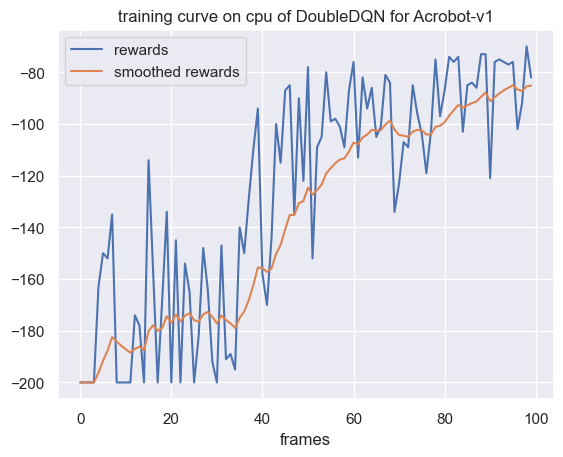

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

def smooth(data: list, weight: float = 0.9):
    '''用于平滑曲线，类似于Tensorboard中的smooth曲线
    '''
    last = data[0] 
    smoothed = []
    for point in data:
        smoothed_val = last * weight + (1 - weight) * point  # 计算平滑值
        smoothed.append(smoothed_val)                    
        last = smoothed_val                                
    return smoothed

def plot_rewards(cfg, frames, rewards):
    ''' 画图
    '''
    sns.set_theme(style="darkgrid")
    plt.figure()  # 创建一个图形实例，方便同时多画几个图
    plt.title(f"{cfg.mode}ing curve on {cfg.device} of {cfg.algo_name} for {cfg.env_id}")
    plt.xlabel('frames')
    plt.plot(frames, rewards, label='rewards')
    plt.plot(frames, smooth(rewards), label='smoothed rewards')
    plt.legend()
    plt.show()

def print_cfgs(cfg):
    ''' 打印参数
    '''
    cfg_dict = vars(cfg)
    print("Hyperparameters:")
    print(''.join(['=']*80))
    tplt = "{:^20}\t{:^20}\t{:^20}"
    print(tplt.format("Name", "Value", "Type"))
    for k,v in cfg_dict.items():
        if v.__class__.__name__ == 'list':
            v = str(v)
        print(tplt.format(k,v,str(type(v))))   
    print(''.join(['=']*80))

def all_seed(seed: int = 0):
    ''' 设置随机种子
    '''
    if seed == 0:
        return
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed) # config for CPU
    torch.cuda.manual_seed(seed) # config for GPU
    os.environ['PYTHONHASHSEED'] = str(seed) # config for python scripts
    # config for cudnn
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False  

# 获取参数
cfg = Config() 
all_seed(cfg.seed)
print_cfgs(cfg)
res = train(cfg)
plot_rewards(cfg, res['frames'], res['rewards'])
